In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats, optimize
%cd ..
from src.causal_model import CausalModel
from src.arima_model import ArimaModel
from src.data_loader import OccupancyData, CaseData
from src.utils import load_config
%cd -

/workspaces/hospitalization-model
/workspaces/hospitalization-model/notebooks


In [2]:
dates = load_config("../config/150_dates.yaml")["dates"]
print(dates)

['2020-12-15', '2020-12-19', '2020-12-23', '2020-12-27', '2021-01-01', '2021-01-05', '2021-01-09', '2021-01-14', '2021-01-18', '2021-01-22', '2021-01-26', '2021-01-31', '2021-02-04', '2021-02-08', '2021-02-13', '2021-02-17', '2021-02-21', '2021-02-25', '2021-03-02', '2021-03-06', '2021-03-10', '2021-03-15', '2021-03-19', '2021-03-23', '2021-03-27', '2021-04-01', '2021-04-05', '2021-04-09', '2021-04-14', '2021-04-18', '2021-04-22', '2021-04-26', '2021-05-01', '2021-05-05', '2021-05-09', '2021-05-14', '2021-05-18', '2021-05-22', '2021-05-26', '2021-05-31', '2021-06-04', '2021-06-08', '2021-06-13', '2021-06-17', '2021-06-21', '2021-06-25', '2021-06-30', '2021-07-04', '2021-07-08', '2021-07-13', '2021-07-17', '2021-07-21', '2021-07-26', '2021-07-30', '2021-08-03', '2021-08-07', '2021-08-12', '2021-08-16', '2021-08-20', '2021-08-25', '2021-08-29', '2021-09-02', '2021-09-06', '2021-09-11', '2021-09-15', '2021-09-19', '2021-09-24', '2021-09-28', '2021-10-02', '2021-10-06', '2021-10-11', '2021

In [3]:
mat = np.zeros((len(dates), 14))
with open(os.path.join("../benchmarks", f"causal_model.json")) as f:
    benchmark = json.load(f)
    mase = []
    mape = []
    calibration = []
    for (i,date) in enumerate(dates):
        actual = np.array(benchmark["successful_forecasts"][date]["actual"])
        pred = np.array(benchmark["successful_forecasts"][date]["prediction"])
        mat[i, :] =  (actual - pred) / pred
intervals = []
for i in range(14):
    kde = stats.gaussian_kde(mat[:, i])
    left = optimize.brentq(lambda x: kde.integrate_box_1d(-np.inf, x) - 0.025, -1, 0)
    right = optimize.brentq(lambda x: kde.integrate_box_1d(-np.inf, x) - 0.975, 0, 1)
    intervals.append((left, right))
    print(f"Interval for {i+1} days ahead: [{left:.2f}, {right:.2f}]")

Interval for 1 days ahead: [-0.18, 0.21]
Interval for 2 days ahead: [-0.23, 0.27]
Interval for 3 days ahead: [-0.24, 0.28]
Interval for 4 days ahead: [-0.29, 0.28]
Interval for 5 days ahead: [-0.36, 0.35]
Interval for 6 days ahead: [-0.36, 0.40]
Interval for 7 days ahead: [-0.40, 0.42]
Interval for 8 days ahead: [-0.44, 0.44]
Interval for 9 days ahead: [-0.47, 0.46]
Interval for 10 days ahead: [-0.50, 0.50]
Interval for 11 days ahead: [-0.52, 0.49]
Interval for 12 days ahead: [-0.56, 0.53]
Interval for 13 days ahead: [-0.57, 0.59]
Interval for 14 days ahead: [-0.59, 0.57]


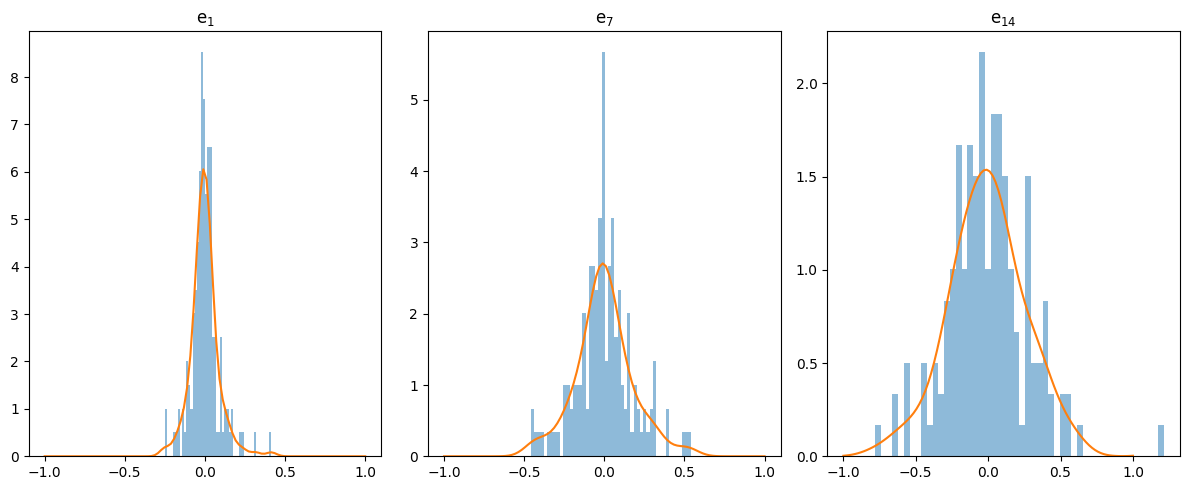

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for (i,j) in enumerate([1, 7, 14]):
    ax[i].hist(mat[:, j-1], bins=50, alpha=0.5, density=True)
    kde = stats.gaussian_kde(mat[:, j-1])
    x = np.linspace(-1, 1, 100)
    ax[i].plot(x, kde(x))
    ax[i].set_title("$\mathregular{e_{" + str(j) + "}}$")
plt.tight_layout()
plt.savefig("plots/causal_model_distributions.pdf")
plt.show()

In [5]:
for i in intervals:
    print(f"- [{i[0]:.16f}, {i[1]:.16f}]")

- [-0.1836671371345115, 0.2090840469845392]
- [-0.2300682724160208, 0.2706180347334238]
- [-0.2442717374300161, 0.2779512047448544]
- [-0.2912202084972838, 0.2802274424385820]
- [-0.3618448626107345, 0.3467947367565468]
- [-0.3600474168052585, 0.4011425162252915]
- [-0.4016169345715997, 0.4179564841019137]
- [-0.4382791560927654, 0.4385244346738312]
- [-0.4700790693770202, 0.4605144206887942]
- [-0.4995606897488106, 0.5043095536403049]
- [-0.5225196026809600, 0.4919340148868756]
- [-0.5586588063058118, 0.5333208736123471]
- [-0.5702121012566000, 0.5917988080396412]
- [-0.5937915294730143, 0.5715164292453496]


In [6]:
config = load_config("../config/general.yaml", "../config/causal_model.yaml")
occupancy_data = OccupancyData("../data/hospitalization.csv")
case_data = CaseData("../data/age_groups.csv")

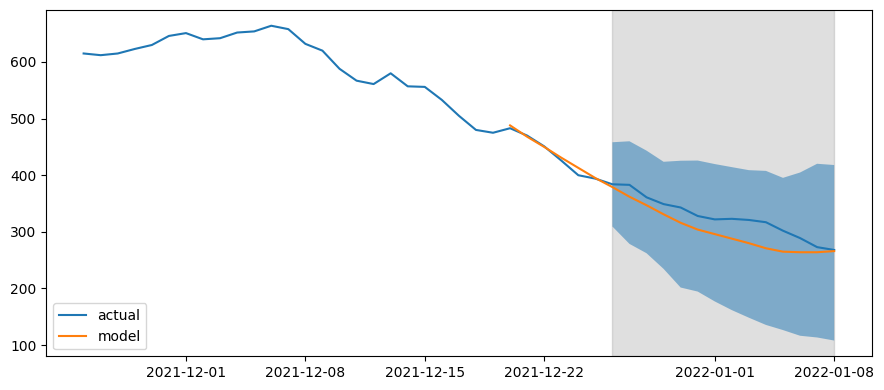

In [7]:
BOUNDS = [
    config["causal_model"]["param_ranges"]["hospitalization_p"],
    config["causal_model"]["param_ranges"]["poisson_lambda"],
    config["causal_model"]["param_ranges"]["truncnorm_loc"],
    config["causal_model"]["param_ranges"]["truncnorm_scale"]
]
causal_model = CausalModel(
    hospitalization_p=config["causal_model"]["params"]["hospitalization_p"],
    poisson_lambda=config["causal_model"]["params"]["poisson_lambda"],
    truncnorm_loc=config["causal_model"]["params"]["truncnorm_loc"],
    truncnorm_scale=config["causal_model"]["params"]["truncnorm_scale"],
    state=config["general"]["state"],
    bed_type=config["general"]["type"],
    age_groups=config["general"]["age_groups"],
    from_date="2021-12-20",
    to_date="2021-12-25",
    buffer=config["causal_model"]["buffer"],
    case_data=case_data,
    occupancy_data=occupancy_data
)
causal_model.calibrate(15, BOUNDS, config["causal_model"]["max_iter"])
causal_model.update(to_date="2022-01-08")
plt.figure(figsize=(9, 4))
quantiles = pd.DataFrame(intervals, columns=["lower", "upper"])
x = pd.date_range("2021-12-20", "2022-01-08", freq="D")
y = causal_model.monte_carlo(15)
ref = occupancy_data.get_df("2021-11-25", "2022-01-08", config["general"]["state"], config["general"]["type"])
plt.plot(ref.index, ref["occupancy"], label="actual")
plt.plot(x, y, label="model")
plt.axvspan(x[-14], x[-1], alpha=0.25, color='grey')
plt.fill_between(x[-14:], y[-14:] + quantiles["lower"] * y[-14:], y[-14:] + quantiles["upper"] * y[-14:], alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("plots/causal_model_confidence_interval.pdf")

In [8]:
mat = np.zeros((len(dates), 14))
with open(os.path.join("../benchmarks", f"arima_model.json")) as f:
    benchmark = json.load(f)
    mase = []
    mape = []
    calibration = []
    for (i,date) in enumerate(dates):
        actual = np.array(benchmark["successful_forecasts"][date]["actual"])
        pred = np.array(benchmark["successful_forecasts"][date]["prediction"])
        mat[i, :] =  (actual - pred) / pred
intervals = []
for i in range(14):
    kde = stats.gaussian_kde(mat[:, i])
    left = optimize.brentq(lambda x: kde.integrate_box_1d(-np.inf, x) - 0.025, -1, 0)
    right = optimize.brentq(lambda x: kde.integrate_box_1d(-np.inf, x) - 0.975, 0, 1)
    intervals.append((left, right))
    print(f"Interval for {i+1} days ahead: [{left:.2f}, {right:.2f}]")

Interval for 1 days ahead: [-0.21, 0.21]
Interval for 2 days ahead: [-0.22, 0.26]
Interval for 3 days ahead: [-0.26, 0.31]
Interval for 4 days ahead: [-0.33, 0.27]
Interval for 5 days ahead: [-0.36, 0.33]
Interval for 6 days ahead: [-0.42, 0.43]
Interval for 7 days ahead: [-0.44, 0.52]
Interval for 8 days ahead: [-0.50, 0.52]
Interval for 9 days ahead: [-0.53, 0.59]
Interval for 10 days ahead: [-0.59, 0.67]
Interval for 11 days ahead: [-0.62, 0.73]
Interval for 12 days ahead: [-0.64, 0.77]
Interval for 13 days ahead: [-0.68, 0.86]
Interval for 14 days ahead: [-0.72, 0.88]


In [9]:
for i in intervals:
    print(f"- [{i[0]:.16f}, {i[1]:.16f}]")

- [-0.2053274554212326, 0.2115620512355245]
- [-0.2184691728002145, 0.2572072385658202]
- [-0.2550310477788444, 0.3068024338728000]
- [-0.3250109486833778, 0.2654030170715560]
- [-0.3620836537114980, 0.3308524611426735]
- [-0.4188163967379937, 0.4337470757960235]
- [-0.4421066325589466, 0.5165740894681483]
- [-0.4996789475022796, 0.5202183020138862]
- [-0.5329821177347914, 0.5879731694248348]
- [-0.5866868093232404, 0.6721274208751121]
- [-0.6175698897926499, 0.7315502141430510]
- [-0.6355047884897528, 0.7729127812349806]
- [-0.6756073384507323, 0.8576202069061912]
- [-0.7213671255496500, 0.8781696283073476]


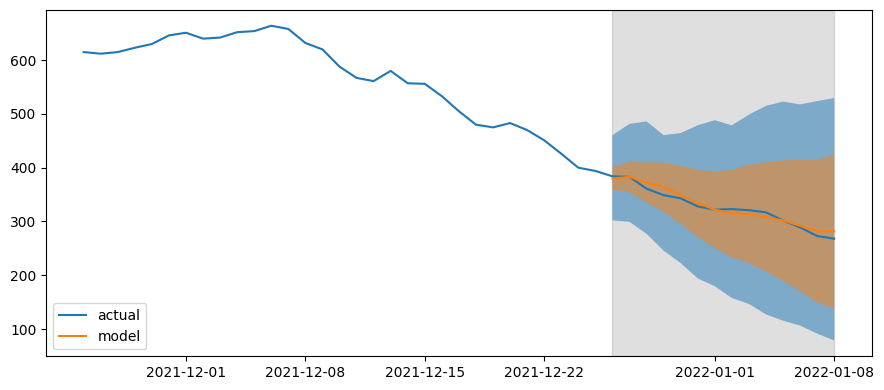

In [10]:
model = ArimaModel(
    config["general"]["state"], 
    config["general"]["type"], 
    config["general"]["age_groups"], 
    from_date=occupancy_data.min_date(), 
    to_date="2021-12-25", 
    case_data=case_data,
    occupancy_data=occupancy_data
)
model.calibrate()
plt.figure(figsize=(9, 4))
quantiles = pd.DataFrame(intervals, columns=["lower", "upper"])
x = pd.date_range("2021-11-25", "2022-01-08", freq="D")
pred, conf_int = model.predict(14)
ref = occupancy_data.get_array("2021-11-25", "2022-01-08", config["general"]["state"], config["general"]["type"])
plt.plot(x, ref, label="actual")
plt.plot(x[-14:], pred, label="model")
plt.axvspan(x[-14], x[-1], alpha=0.25, color='grey')
plt.fill_between(x[-14:], pred + quantiles["lower"] * pred, pred + quantiles["upper"] * pred, alpha=0.5)
plt.fill_between(x[-14:], conf_int[:, 0], conf_int[:, 1], alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("plots/arima_confidence_interval.pdf")